#TUIA - Aprendizaje Automático 1

##Trabajo práctico N°1: Regresión lineal

Integrantes:
- Oviedo, María Victoria
- Brizuela Cipolletti, Sofía

##Descripción del trabajo

El objetivo de este trabajo es predecir los precios de casas de Boston, implementando técnicas como regresión lineal a partir de un dataset ('house-prices.csv') que contiene características socioeconómicas.

**Características de entrada en orden:**
1. CRIM: tasa de criminalidad per cápita por ciudad
2. ZN: proporción de terrenos residenciales zonificados para lotes de más de 25 000 pies cuadrados
3. INDUS: proporción de acres de negocios no minoristas por ciudad
4. CHAS: variable dummy del río Charles (1 si el tramo limita con el río; 0 de lo contrario)
5. NOX: concentración de óxidos de nitrógeno (partes por 10 millones) [parts 10M]
6. RM: número promedio de habitaciones por vivienda
7. AGE: proporción de unidades ocupadas por sus propietarios construidas antes de 1940
8. DIS: distancias ponderadas a cinco centros de empleo de Boston
9. RAD: índice de accesibilidad a las autopistas radiales
10. TAX: tasa de impuesto sobre la propiedad a valor completo por $10,000 [$ 10k]
11. PTRATIO: proporción alumno-maestro por ciudad
12. B: El resultado de la ecuación B=1000(Bk - 0.63)^2 donde Bk es la proporción de negros por ciudad
13. LSTAT: % de población de menor estatus socioeconómico

**Variable de salida (target):**
14. MEDV: Valor mediano de las viviendas ocupadas por sus propietarios en miles de dólares [k$]

In [ ]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, ElasticNetCV, LassoCV, SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer

import statsmodels.api as sm
from scipy import stats

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/AA/house-prices-tp.csv")
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.07151,0.0,4.49,0.0,0.449,6.121,56.8,3.7476,3.0,247.0,18.5,395.15,8.44,22.2
1,0.08265,0.0,13.92,0.0,0.437,6.127,18.4,5.5027,4.0,289.0,16.0,396.90,8.58,23.9
2,0.12816,12.5,6.07,0.0,0.409,5.885,33.0,6.4980,4.0,345.0,18.9,396.90,8.79,20.9
3,0.08873,21.0,5.64,0.0,0.439,5.963,45.7,6.8147,4.0,243.0,16.8,395.56,13.45,19.7
4,0.11432,0.0,8.56,0.0,0.520,6.781,71.3,2.8561,5.0,384.0,20.9,395.58,7.67,26.5


###Análisis descriptivo y exploratorio

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 556 entries, 0 to 555
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     533 non-null    float64
 1   ZN       534 non-null    float64
 2   INDUS    541 non-null    float64
 3   CHAS     533 non-null    float64
 4   NOX      532 non-null    float64
 5   RM       535 non-null    float64
 6   AGE      532 non-null    float64
 7   DIS      541 non-null    float64
 8   RAD      528 non-null    float64
 9   TAX      538 non-null    float64
 10  PTRATIO  528 non-null    float64
 11  B        534 non-null    float64
 12  LSTAT    534 non-null    float64
 13  MEDV     535 non-null    float64
dtypes: float64(14)
memory usage: 60.9 KB


In [ ]:
# Verificamos valores faltantes
data.isnull().sum()

,0
CRIM,23
ZN,22
INDUS,15
CHAS,23
NOX,24
RM,21
AGE,24
DIS,15
RAD,28
TAX,18


Decidimos eliminar las filas donde la variable target contenga valores faltantes, y luego, eliminamos las filas que contengan más de 4 variables faltantes dado consideramos que es probable que la información sea insuficiente para realizar el análisis

In [ ]:
# Primero eliminamos las filas donde la variable faltante sea MEDV
data = data.dropna(subset=['MEDV'])
# Luego se eliminan las filas que tengan más de 4 variables faltantes
data = data.dropna(thresh=data.shape[1] - 4)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 525 entries, 0 to 555
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     520 non-null    float64
 1   ZN       519 non-null    float64
 2   INDUS    525 non-null    float64
 3   CHAS     523 non-null    float64
 4   NOX      522 non-null    float64
 5   RM       523 non-null    float64
 6   AGE      518 non-null    float64
 7   DIS      523 non-null    float64
 8   RAD      518 non-null    float64
 9   TAX      522 non-null    float64
 10  PTRATIO  521 non-null    float64
 11  B        522 non-null    float64
 12  LSTAT    523 non-null    float64
 13  MEDV     525 non-null    float64
dtypes: float64(14)
memory usage: 61.5 KB


Realizamos la división del dataset en train y test, del cual separamos un 80% para entrenamiento y el 20% restante para prueba

In [ ]:
# División de los datos en train y test
X = data.drop(columns='MEDV')
y = data['MEDV']

# Validación cruzada con KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X,y.values.reshape(-1,1),test_size=0.2,random_state = 42)

X_train=pd.DataFrame(X_train,columns=data.drop(columns='MEDV').columns).reset_index(drop=True)
X_test=pd.DataFrame(X_test,columns=data.drop(columns='MEDV').columns).reset_index(drop=True)
y_train = pd.DataFrame(y_train, columns=['MEDV']).reset_index(drop=True)
y_test = pd.DataFrame(y_test, columns=['MEDV']).reset_index(drop=True)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     417 non-null    float64
 1   ZN       415 non-null    float64
 2   INDUS    420 non-null    float64
 3   CHAS     419 non-null    float64
 4   NOX      418 non-null    float64
 5   RM       418 non-null    float64
 6   AGE      414 non-null    float64
 7   DIS      418 non-null    float64
 8   RAD      414 non-null    float64
 9   TAX      418 non-null    float64
 10  PTRATIO  417 non-null    float64
 11  B        417 non-null    float64
 12  LSTAT    418 non-null    float64
dtypes: float64(13)
memory usage: 42.8 KB


In [ ]:
# Verificamos valores faltantes
X_train.isnull().sum()

,0
CRIM,3
ZN,5
INDUS,0
CHAS,1
NOX,2
RM,2
AGE,6
DIS,2
RAD,6
TAX,2


Decidimos imputar los datos faltantes de la mayoría de las columnas con la mediana, excepto en la columna 'CHAS' dado que es una variable categórica e imputamos con la moda

In [ ]:
# Columnas a imputar con la mediana
var_mediana = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'RAD']

# Columna a imputar con la moda
var_moda = ['CHAS']

# Imputación datos faltantes
imputador_mediana = SimpleImputer(strategy='median')
X_train_mediana = imputador_mediana.fit_transform(X_train[var_mediana])
X_test_mediana = imputador_mediana.transform(X_test[var_mediana])

imputador_moda = SimpleImputer(strategy='most_frequent')
X_train_moda = imputador_moda.fit_transform(X_train[var_moda])
X_test_moda = imputador_moda.transform(X_test[var_moda])

# Concatenar después de imputar
X_train_imputado = pd.concat([pd.DataFrame(X_train_mediana, columns=var_mediana),
                              pd.DataFrame(X_train_moda, columns=var_moda)], axis=1)

X_test_imputado = pd.concat([pd.DataFrame(X_test_mediana, columns=var_mediana),
                             pd.DataFrame(X_test_moda, columns=var_moda)], axis=1)

# Concatenar con la variable objetivo
data_train = pd.concat([X_train_imputado, pd.DataFrame(y_train, columns=['MEDV'])], axis=1)
data_test = pd.concat([X_test_imputado, pd.DataFrame(y_test, columns=['MEDV'])], axis=1)


# Verificar después de la imputación
print(data_train.isnull().sum())
print(data_test.isnull().sum())

CRIM       0
ZN         0
INDUS      0
NOX        0
RM         0
AGE        0
DIS        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
RAD        0
CHAS       0
MEDV       0
dtype: int64
CRIM       0
ZN         0
INDUS      0
NOX        0
RM         0
AGE        0
DIS        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
RAD        0
CHAS       0
MEDV       0
dtype: int64


In [ ]:
# Resumen estadístico
summary_stats = data_train.describe()
print(summary_stats)

             CRIM          ZN       INDUS         NOX          RM         AGE  \
count  420.000000  420.000000  420.000000  420.000000  420.000000  420.000000   
mean     5.055290   12.359496   11.276347    0.555148    6.263955   67.253426   
std     11.887324   24.512218    6.899720    0.114720    0.727883   28.360322   
min      0.006320    0.000000    0.460000    0.385000    3.839536    2.900000   
25%      0.082155    0.000000    5.190000    0.452000    5.873500   42.275000   
50%      0.263630    0.000000    9.795000    0.538000    6.189000   74.850000   
75%      4.767310   18.500000   18.100000    0.624000    6.626000   93.300000   
max     88.976200  100.000000   27.740000    0.871000    8.780000  100.000000   

              DIS         TAX     PTRATIO           B       LSTAT         RAD  \
count  420.000000  420.000000  420.000000  420.000000  420.000000  420.000000   
mean     3.940571  412.062241   18.577050  351.424796   13.001499    9.726684   
std      2.203396  170.1472

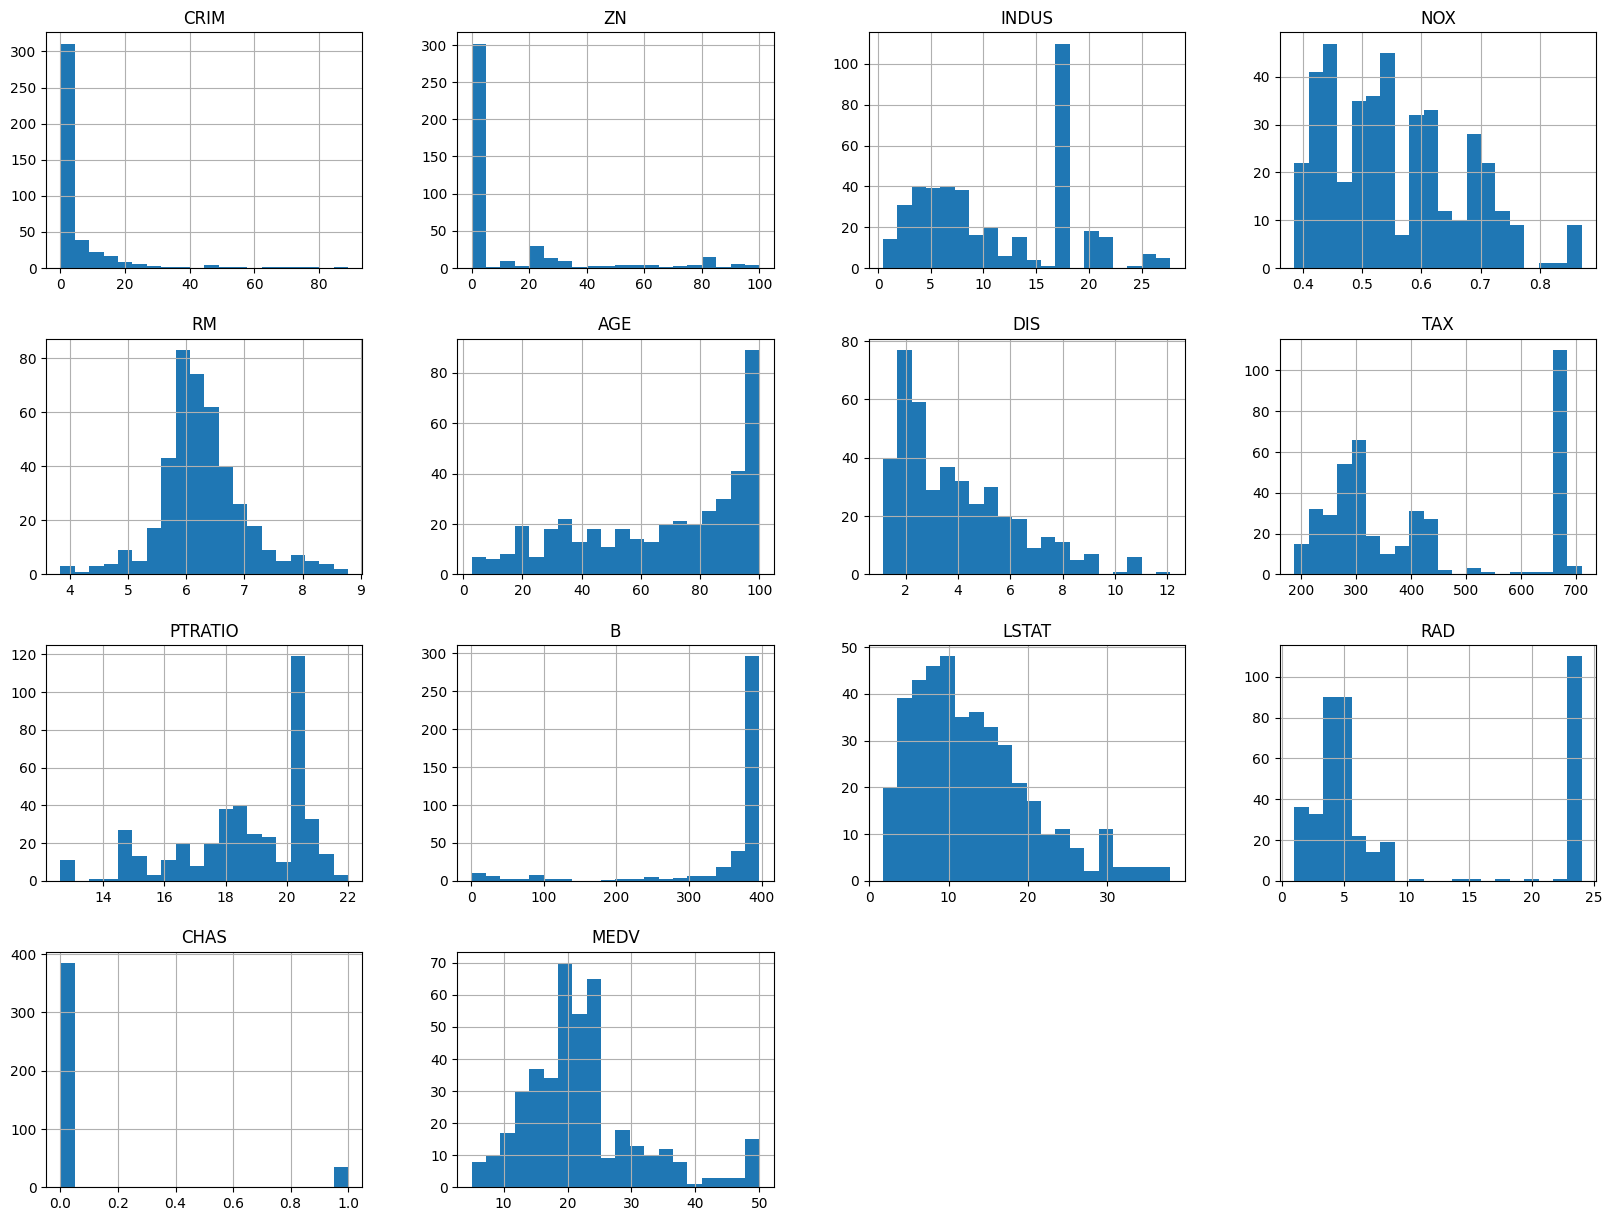

In [ ]:
# Visualización de las distribuciones de las variables
data_train.hist(bins=20, figsize=(20,15))
plt.show()

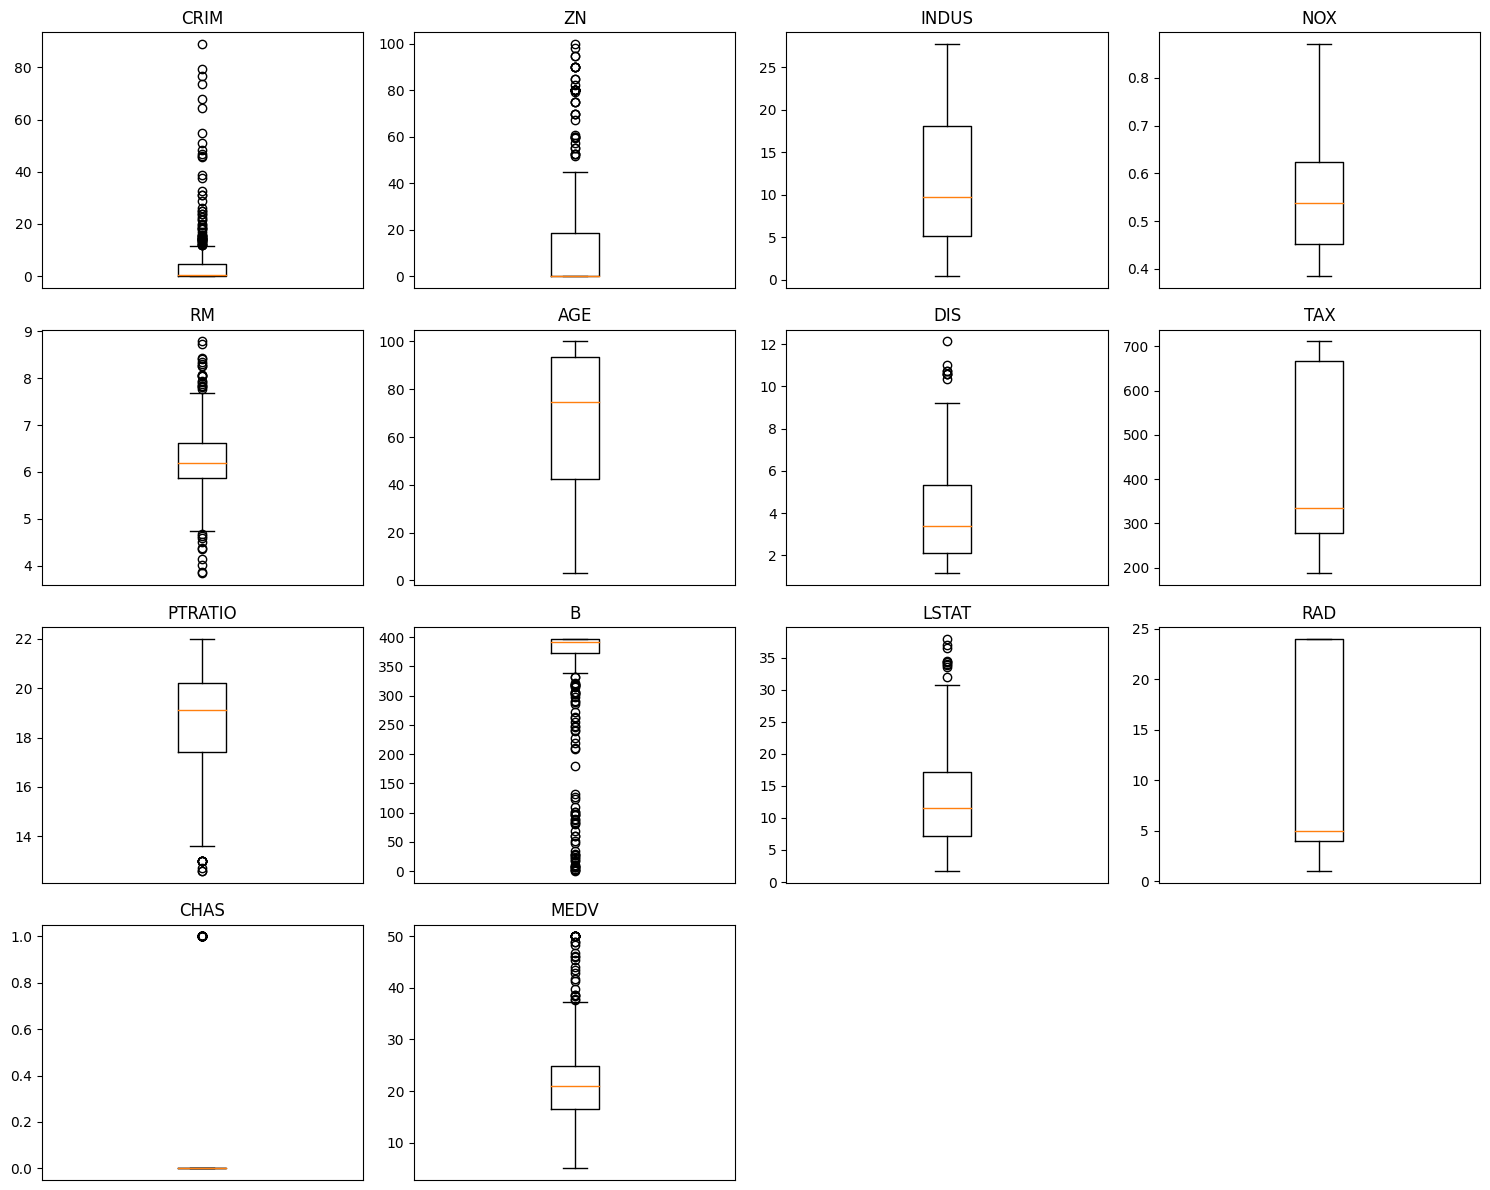

In [ ]:
# Creamos diagrama de caja individual para cada variable
plt.figure(figsize=(15, 12))

for i, column in enumerate(data_train.columns):
    plt.subplot(4, 4, i+1)  # Ajustamos filas y columnas según la cantidad de variables (en este caso 4x4 para 13 variables)
    plt.boxplot(data_train[column].dropna())  # Aseguramos que se ignoren valores faltantes
    plt.title(column)
    plt.xticks([])  # Eliminamos marcas en el eje x para un aspecto más limpio

plt.tight_layout()  # Aseguramos que los gráficos no se solapen
plt.show()

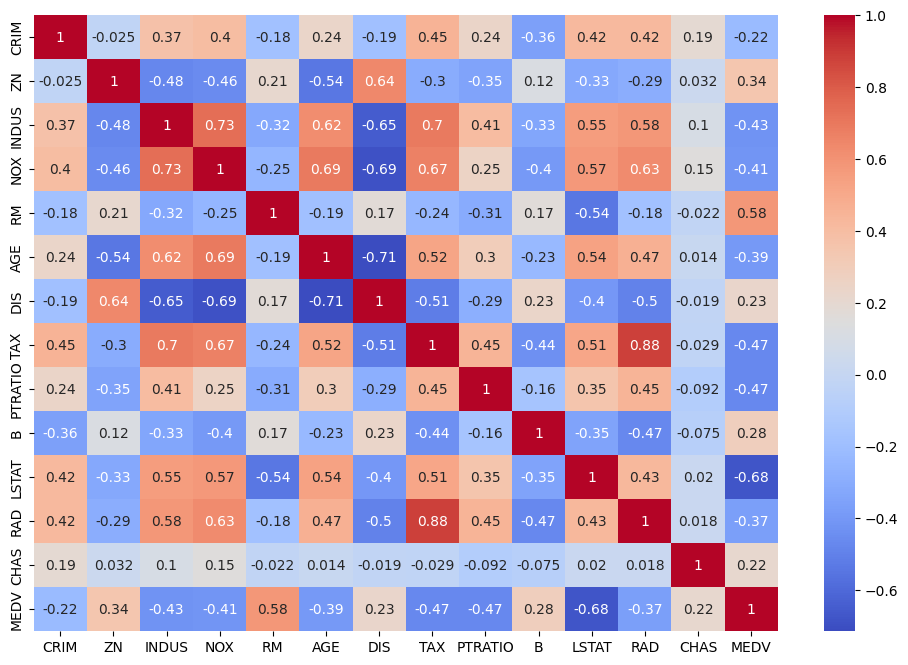

In [ ]:
# Matriz de correlación
corr_matrix = data_train.corr()

# Visualización con un mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

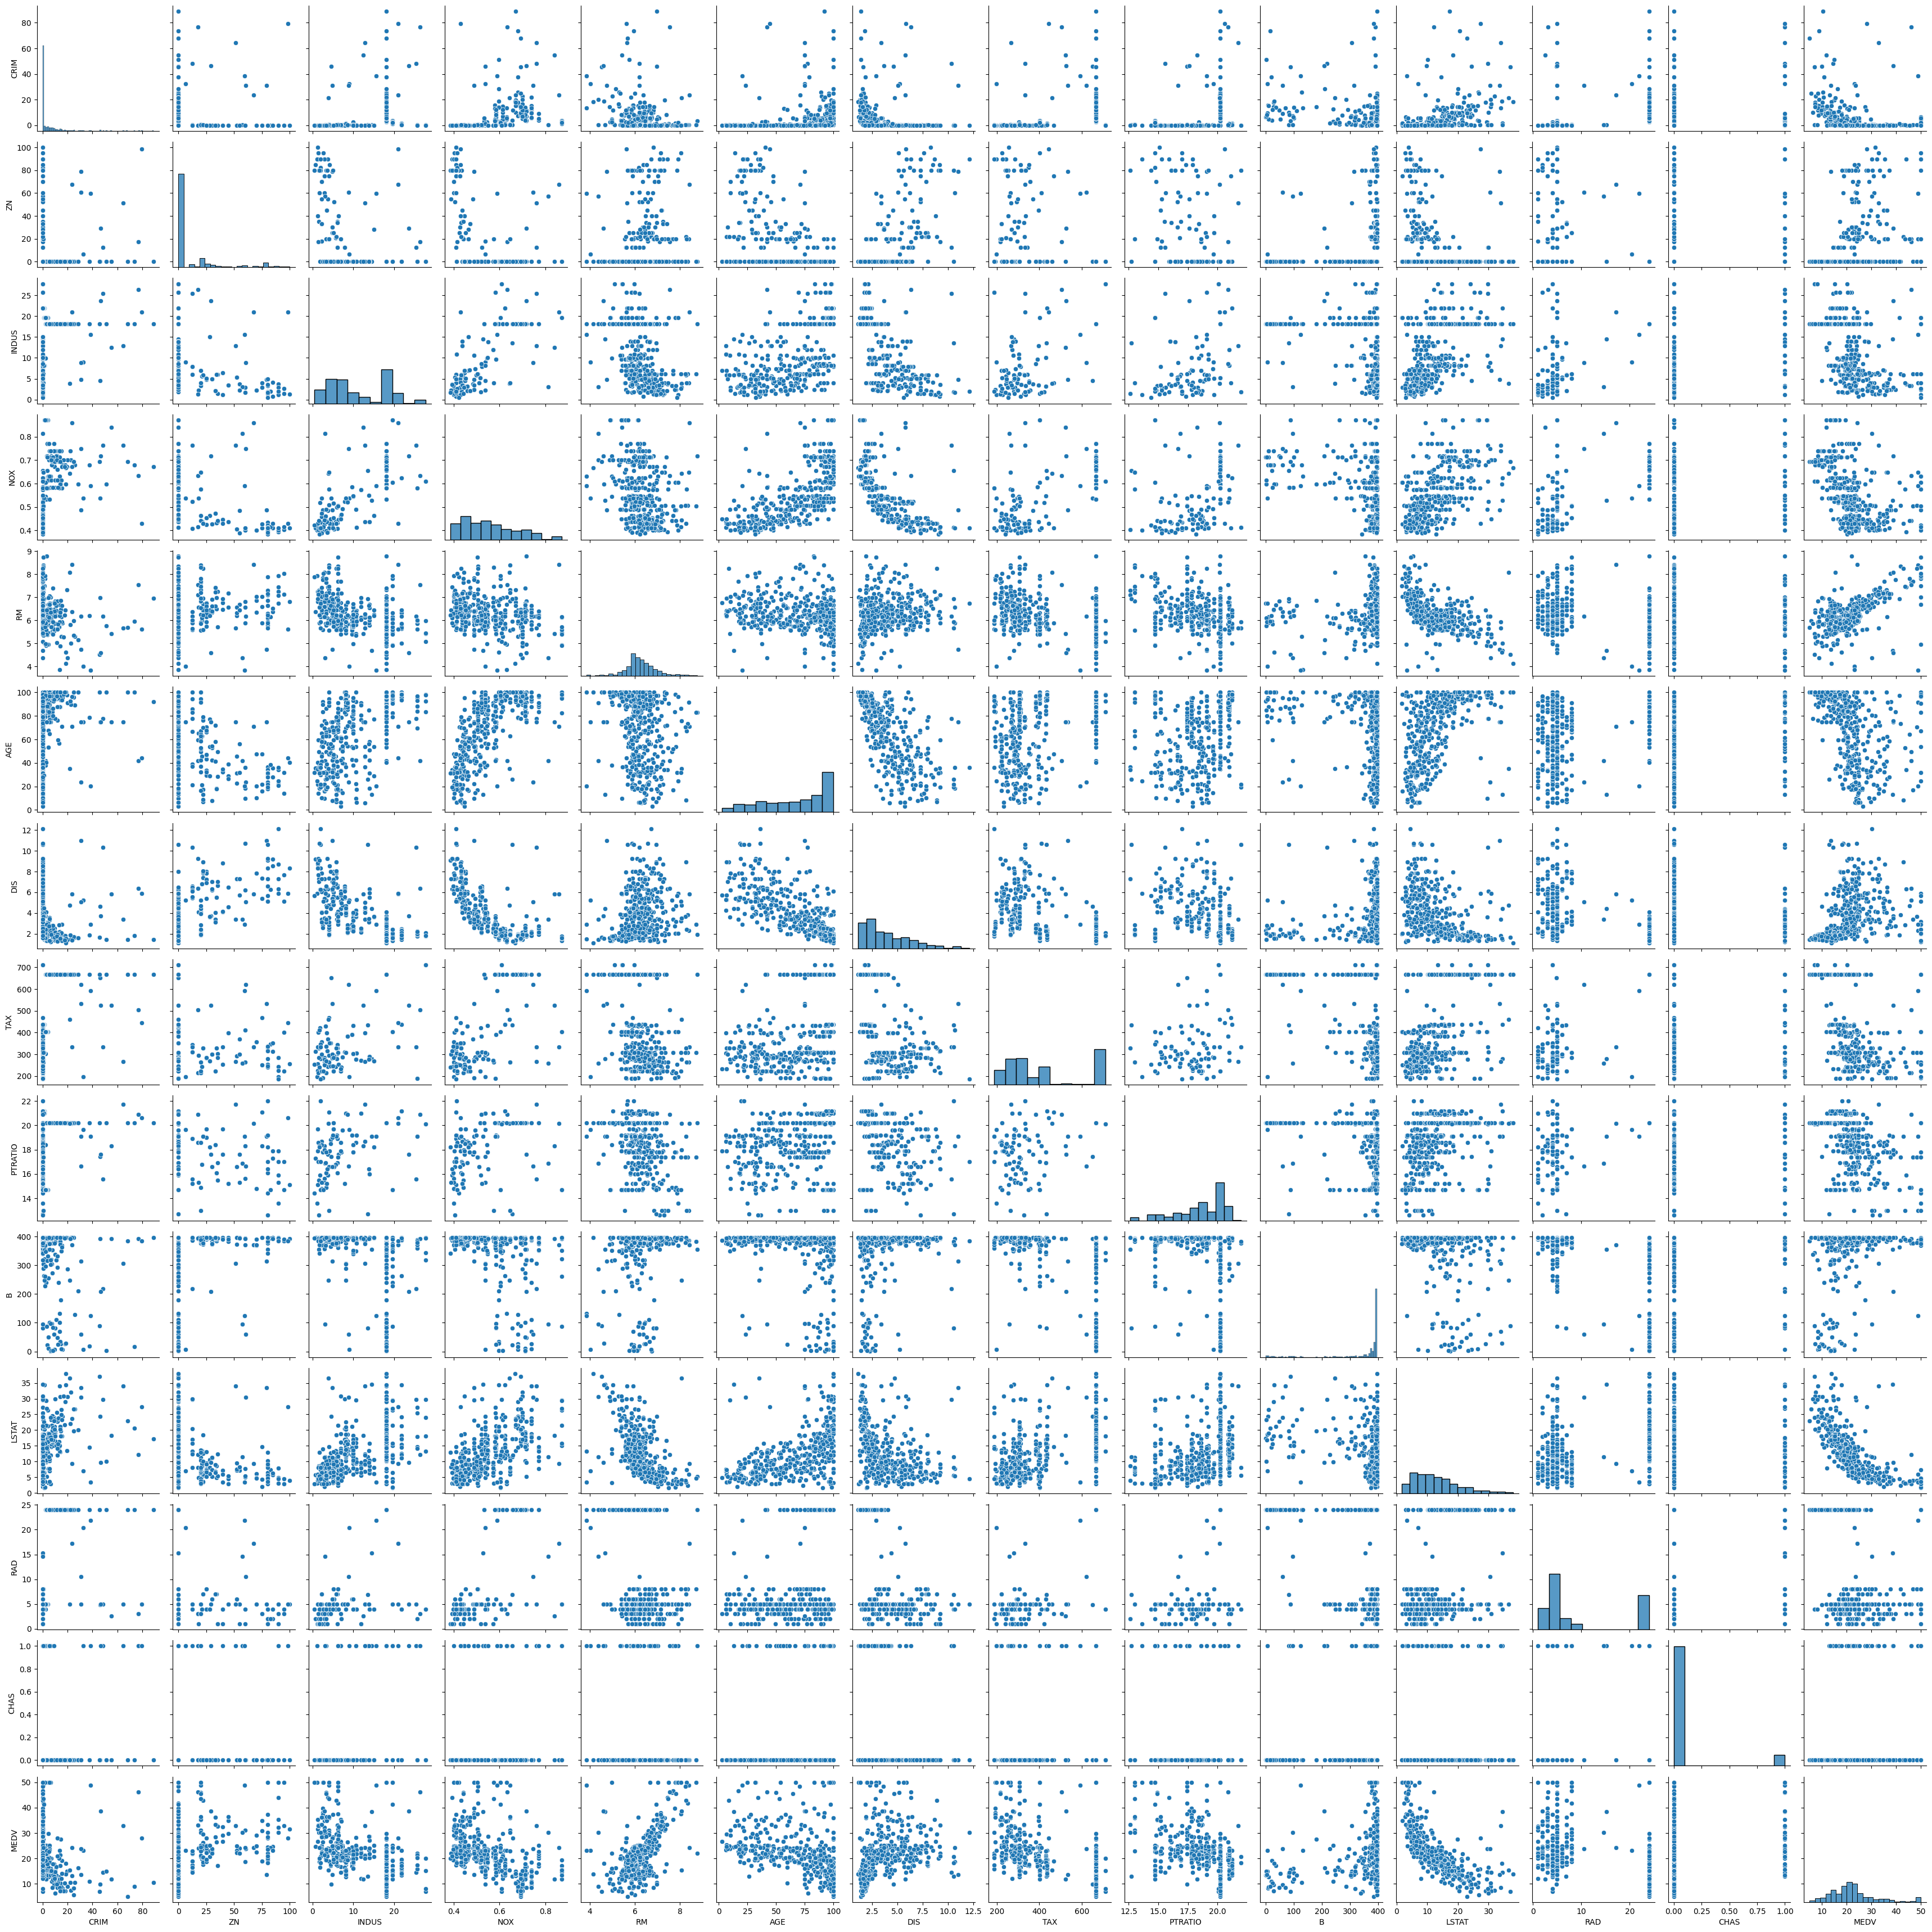

In [ ]:
sns.pairplot(data_train)
plt.show()

In [ ]:
pt = PowerTransformer()

# Ajustamos y transformamos los datos de entrenamiento
X_train_scaled = pt.fit_transform(X_train_imputado)

# Solo transformamos los datos de prueba
X_test_scaled = pt.transform(X_test_imputado)

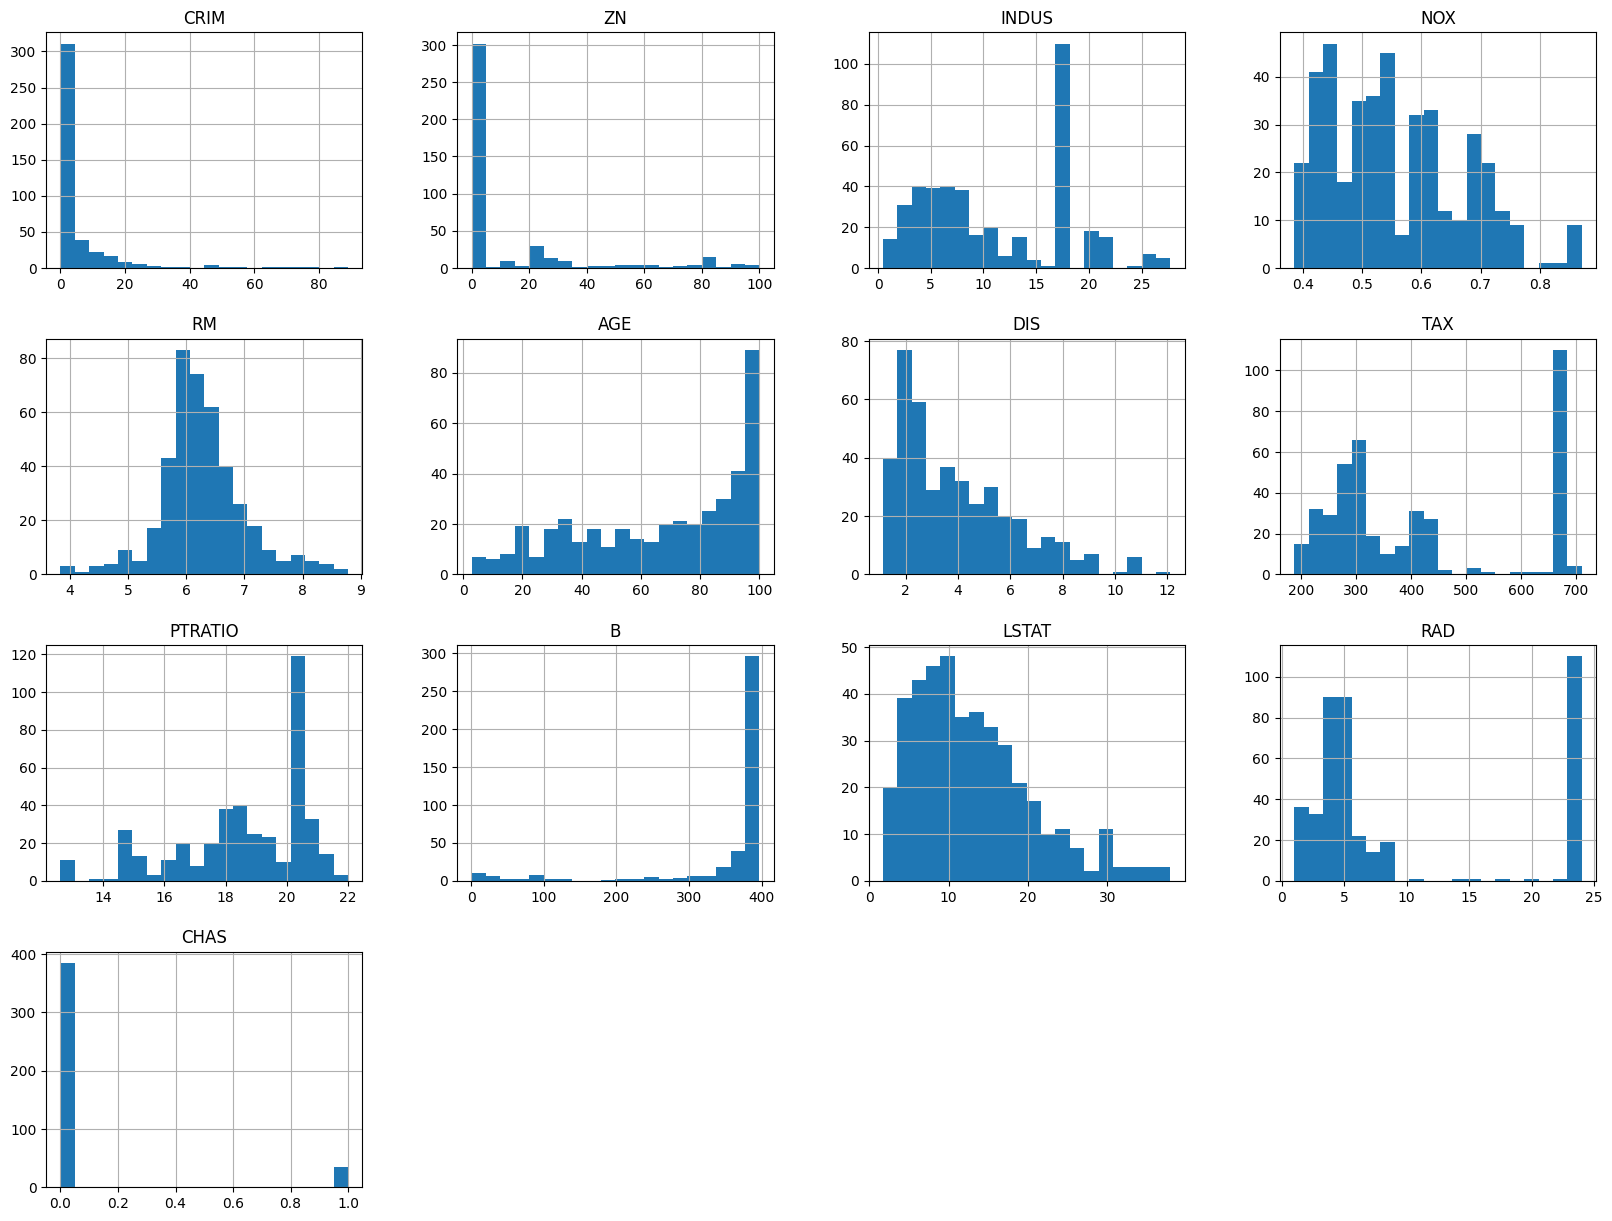

In [ ]:
# Visualización de las distribuciones de las variables
X_train_imputado.hist(bins=20, figsize=(20,15))
plt.show()

In [ ]:
# Regresión lineal múltiple
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_train = lr.predict(X_train_scaled)
y_pred_test = lr.predict(X_test_scaled)

# Métricas para regresión lineal
def print_metrics(y_true, y_pred, dataset_type='Train'):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{dataset_type} MSE: {mse}")
    print(f"{dataset_type} RMSE: {rmse}")
    print(f"{dataset_type} MAE: {mae}")
    print(f"{dataset_type} R2: {r2}")

print('métricas Train')
print_metrics(y_train, y_pred_train, 'Train')
print('métricas Test')
print_metrics(y_test, y_pred_test, 'Test')

métricas Train
Train MSE: 23.713508609758122
Train RMSE: 4.8696517955350895
Train MAE: 3.4519058179497506
Train R2: 0.7173336121474618
métricas Test
Test MSE: 38.13008942880221
Test RMSE: 6.174956633758832
Test MAE: 4.210904834536325
Test R2: 0.6121244964950593


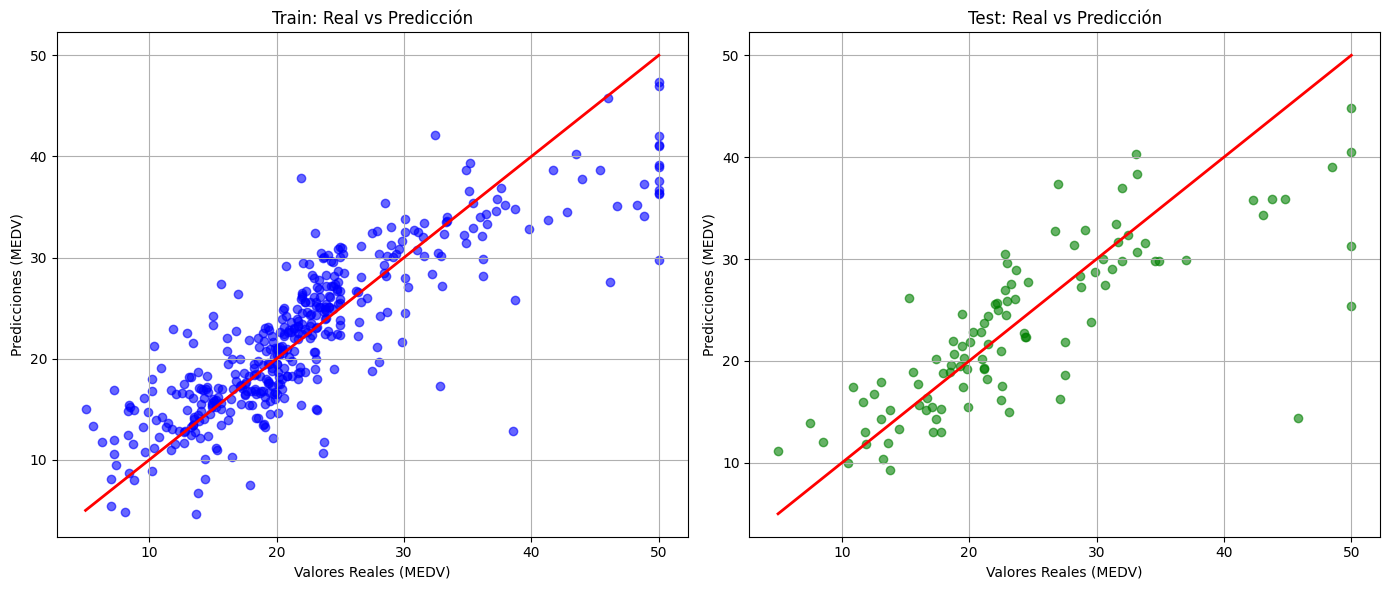

In [ ]:
# Gráfica de predicciones vs valores reales para el conjunto de entrenamiento y prueba
plt.figure(figsize=(14, 6))

# Gráfico para el conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_pred_train, alpha=0.6, color='blue')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r', lw=2)
plt.title('Train: Real vs Predicción')
plt.xlabel('Valores Reales (MEDV)')
plt.ylabel('Predicciones (MEDV)')
plt.grid(True)

# Gráfico para el conjunto de prueba
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r', lw=2)
plt.title('Test: Real vs Predicción')
plt.xlabel('Valores Reales (MEDV)')
plt.ylabel('Predicciones (MEDV)')
plt.grid(True)

# Mostrar las gráficas
plt.tight_layout()
plt.show()

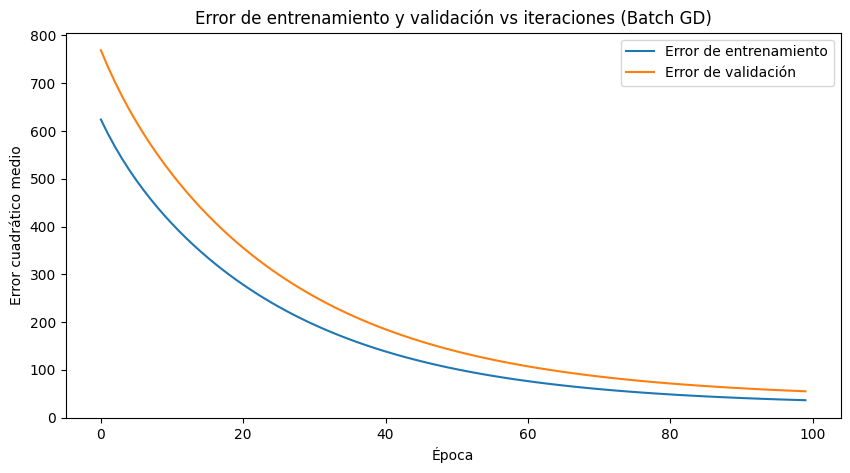

<ipython-input-186-918fd751f1cf>:72: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_sample = y_train.iloc[j][0]


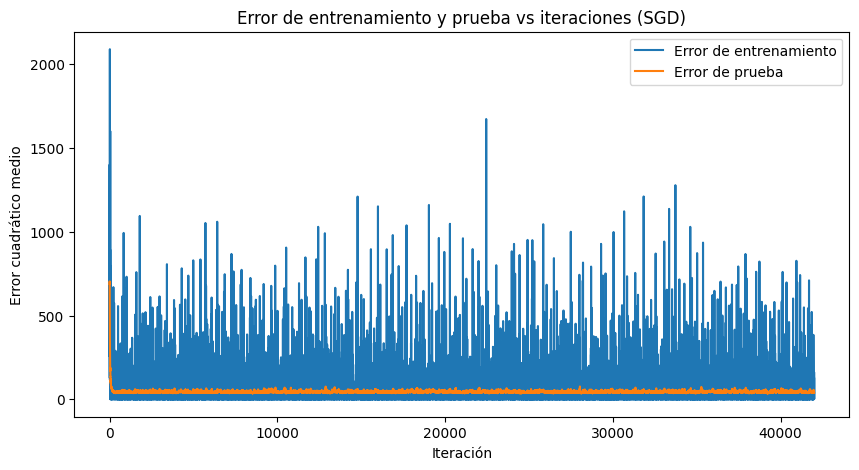

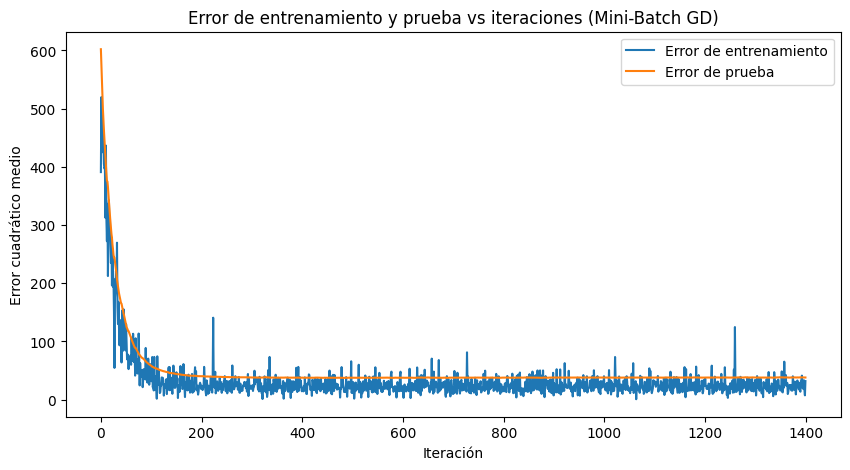

In [ ]:
#  Gradiente descendiente
def gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100):
    n = X_train.shape[0]
    m = X_train.shape[1]

    o = X_val.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))

    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for _ in range(epochs):
        # Predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W)
        error_train = y_train.values - prediction_train
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Predicción y error de prueba
        prediction_test = np.matmul(X_val, W)
        error_test = y_val.values - prediction_test
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum
        gradient = np.transpose(grad_mul).reshape(-1, 1)

        W = W - (lr * gradient)

    # Graficar errores
    plt.figure(figsize=(10, 5))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de validación')
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y validación vs iteraciones (Batch GD)')
    plt.show()

    return W

#  Gradiente Descendiente Estocástico
def stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):
    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train.iloc[permutation]

        for j in range(n):
            # Obtener una muestra aleatoria para hacer SGD
            x_sample = X_train[j]
            y_sample = y_train.iloc[j][0]

            prediction = np.matmul(x_sample, W)
            error = y_sample - prediction
            train_mse = error ** 2
            train_errors.append(train_mse)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

            gradient = -2 * error * x_sample.T.reshape(-1, 1)
            W = W - (lr * gradient)

    plt.figure(figsize=(10, 5))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (SGD)')
    plt.show()

    return W

#  Mini-Batch gradiente descendiente
def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, batch_size=11):
    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train.iloc[permutation]

        for j in range(0, n, batch_size):
            # Obtener un mini-batch de datos
            x_batch = X_train[j:j+batch_size, :]
            y_batch = y_train[j:j+batch_size].values.reshape(-1, 1)

            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction
            train_mse = np.mean(error ** 2)
            train_errors.append(train_mse)

            gradient = -2 * np.matmul(x_batch.T, error) / batch_size
            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(10, 5))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (Mini-Batch GD)')
    plt.show()

    return W

# Ejemplo de uso con los tres métodos
W_gd = gradient_descent(X_train_scaled, y_train, X_test_scaled, y_test, lr=0.01, epochs=100)
W_sgd = stochastic_gradient_descent(X_train_scaled, y_train, X_test_scaled, y_test, lr=0.01, epochs=100)
W_mbgd = mini_batch_gradient_descent(X_train_scaled, y_train, X_test_scaled, y_test, lr=0.01, epochs=100, batch_size=32)

Alpha Lasso: 0.04628676790895868
Alpha Ridge: 10.0
Alpha ElasticNet: 0.046074066919931725

Coeficientes del modelo Lasso:
[ 1.54973604  0.77483241 -0.         -0.9964897   1.54368204 -0.24735347
 -2.23958503 -2.14357289 -1.1058055   0.1566602  -5.45244491  0.1889496
  1.67087631]
R2 Lasso: 0.6148986340528815

Coeficientes del modelo Ridge:
[ 1.5687745   0.80050118 -0.00886221 -1.09946142  1.64941208 -0.3992307
 -2.34237225 -2.18988373 -1.14754348  0.24648611 -5.18143576  0.30047603
  1.69232386]
R2 Ridge: 0.6153149072310868

Coeficientes del modelo ElasticNet:
[ 1.41265976  0.78068996 -0.         -0.95488904  1.62806335 -0.32779871
 -2.18731417 -2.08779344 -1.13058139  0.2019188  -5.209074    0.25676908
  1.67210706]
R2 ElasticNet: 0.6157974778856357


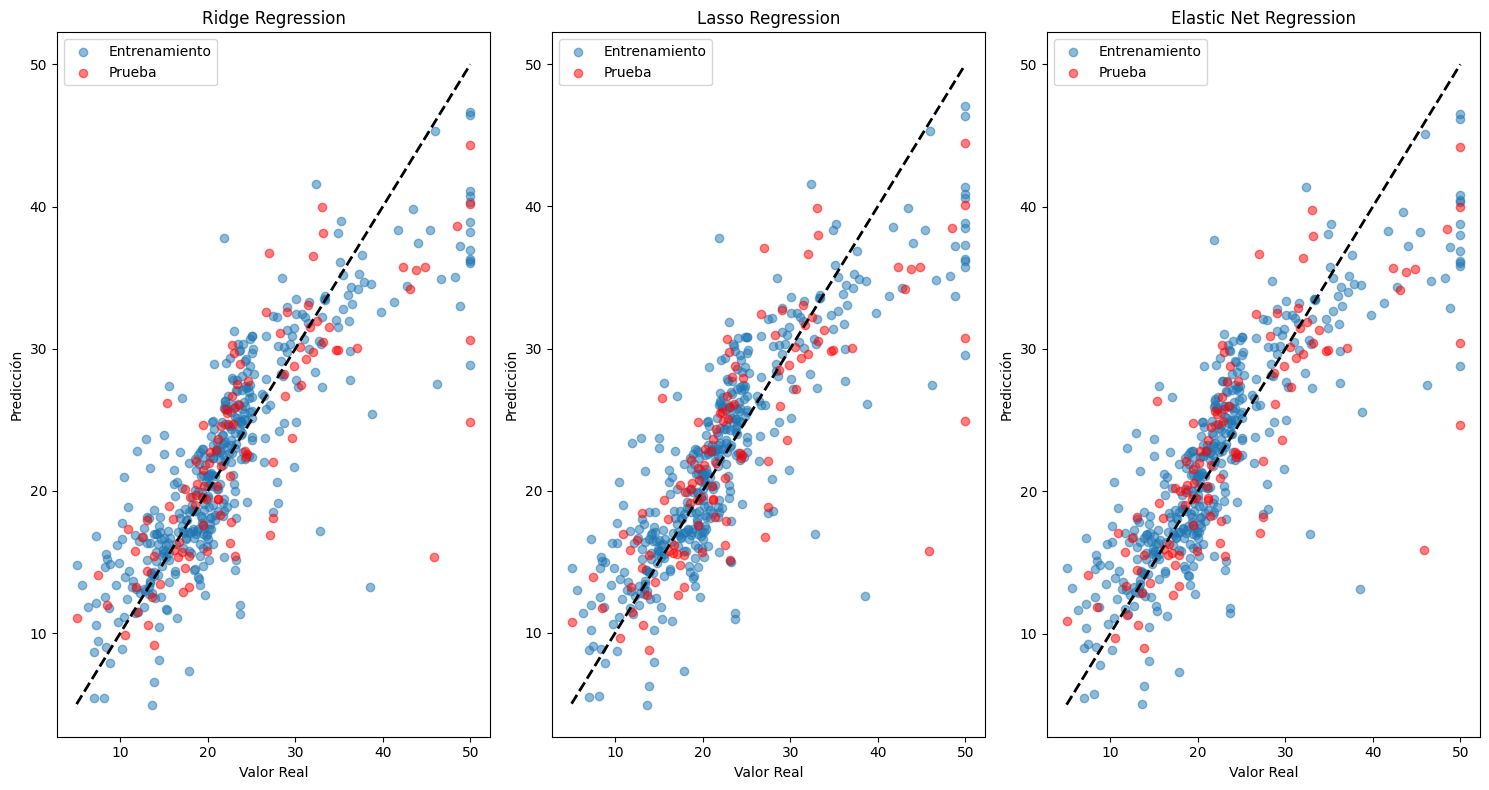

In [ ]:
#  Crear modelos de regresión lineal, Lasso y Ridge
lassoCV = LassoCV(cv=5)
ridgeCV = RidgeCV(cv=5)
elasticnetCV = ElasticNetCV()  # Combina L1 y L2

# Ajustar modelos a los datos
lassoCV.fit(X_train_scaled, y_train)
ridgeCV.fit(X_train_scaled, y_train)
elasticnetCV.fit(X_train_scaled, y_train)

# Mostrar alphas
print("Alpha Lasso:", lassoCV.alpha_)
print("Alpha Ridge:", ridgeCV.alpha_)
print("Alpha ElasticNet:", elasticnetCV.alpha_)

# Mostrar coeficientes
print("\nCoeficientes del modelo Lasso:")
print(lassoCV.coef_)
print("R2 Lasso:", lassoCV.score(X_test_scaled, y_test))

print("\nCoeficientes del modelo Ridge:")
print(ridgeCV.coef_)
print("R2 Ridge:", ridgeCV.score(X_test_scaled, y_test))

print("\nCoeficientes del modelo ElasticNet:")
print(elasticnetCV.coef_)
print("R2 ElasticNet:", elasticnetCV.score(X_test_scaled, y_test))

# Graficar las predicciones
plt.figure(figsize=(15, 8))

# Predicciones para entrenamiento y prueba
y_pred_train_ridge = ridgeCV.predict(X_train_scaled)
y_pred_test_ridge = ridgeCV.predict(X_test_scaled)

y_pred_train_lasso = lassoCV.predict(X_train_scaled)
y_pred_test_lasso = lassoCV.predict(X_test_scaled)

y_pred_train_elastic = elasticnetCV.predict(X_train_scaled)
y_pred_test_elastic = elasticnetCV.predict(X_test_scaled)

# Graficar Ridge
plt.subplot(1, 3, 1)
plt.scatter(y_train, y_pred_train_ridge, alpha=0.5, label='Entrenamiento')
plt.scatter(y_test, y_pred_test_ridge, alpha=0.5, label='Prueba', color='red')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)  # Línea de identidad
plt.title('Ridge Regression')
plt.xlabel('Valor Real')
plt.ylabel('Predicción')
plt.legend()

# Graficar Lasso
plt.subplot(1, 3, 2)
plt.scatter(y_train, y_pred_train_lasso, alpha=0.5, label='Entrenamiento')
plt.scatter(y_test, y_pred_test_lasso, alpha=0.5, label='Prueba', color='red')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)  # Línea de identidad
plt.title('Lasso Regression')
plt.xlabel('Valor Real')
plt.ylabel('Predicción')
plt.legend()

# Graficar Elastic Net
plt.subplot(1, 3, 3)
plt.scatter(y_train, y_pred_train_elastic, alpha=0.5, label='Entrenamiento')
plt.scatter(y_test, y_pred_test_elastic, alpha=0.5, label='Prueba', color='red')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)  # Línea de identidad
plt.title('Elastic Net Regression')
plt.xlabel('Valor Real')
plt.ylabel('Predicción')
plt.legend()

plt.tight_layout()  # Ajustar el layout
plt.show()